## Introdução ##

O acompanhamento nutricional de lactentes e pré-lactentes é um interesse nacional, pois pode revelar verdades sociais e econômicas, além de nutricionais, a respeito de cidades e Estados no Brasil. Também diz respeito a saúde das crianças e das gestantes do Brasil. 

No entanto, esse trabalho é dificultado pelo formato como esses dados são apresentados. Mesmo com o decreto nº 8.777 de 11 de Maio e 2016 (Decreto da política de dados abertos), um importante avanço na legislação brasileira em relação à transparência e à cultura de dados abertos, muitas vezes os dados não são apresentados em um formato facilmente processável por máquina. 

Esse caso é verdade para os dados apresentados no site do [SISVAN](http://dabsistemas.saude.gov.br/sistemas/sisvanV2/relatoriopublico/index), que são disponibilizados como relatórios em planilhas, que precisam ser baixadas através do preenchimento de um formulário. Este trabalho tem o objetivo de contribuir com a produção acadêmica do professor Dr. Jonas Silveira, que deseja esses dados em um formato de fácil utilização. 


## Coletando os dados ##

A primeira etapa, naturalmente, é a de baixar os dados pelo site do SISVAN. No entanto, pela quantidade de relatórios, é um processo demorado e maçante. Por isso, foi necessário automatizar esse trabalho através de uma técnica que pudesse baixar os relatórios automaticamente. A técnica em questão é o WebScraping, que permite coletar dados de páginas da internet de forma automatizada. A ferramenta utilizada foi a biblioteca [Selenium](https://www.seleniumhq.org), que automatiza o uso do navegador e simula cliques como um usuário.

O código do WebScraper pode ser encontrado [aqui](https://github.com/victoraccete/ICD_20182/tree/webScraper). Importante destacar que os relatórios baixados vão automaticamente para o diretório de downloads do seu navegador. Por padrão, é a pasta Downloads. 

## Organizando os dados ##

Como citado anteriormente, os dados não vêm no melhor formato possível para a utilização. Foi necessário ler os relatórios baixados no formato .xls, transformando em um dataframe possível de ser tratado em Python em conjunto com a biblioteca [Pandas](https://pandas.pydata.org). 

O próximo passo foi remover colunas descenessárias. No entanto, ainda assim, teríamos vários conjuntos de dados separados, o que dificultaria a análise. Felizmente, é possível mesclar esses dados e transformar tudo em um único conjunto de dados e exportá-los como um arquivo de valores separados por vírgula, mais conhecido como arquivo csv, um formato de arquivo amplamente utilizado para dados.  

O código completo para ser executado de uma só vez por ser encontrado [aqui](https://github.com/victoraccete/ICD_20182/blob/final_notebook/cleanandmerge.py). 

## Apresentando os dados ##

A visualização em mapas acelera a obtenção dos primeiros insights à respeito da pesquisa e a interatividade do mapa permite com que o usuário ou pesquisador escolha o que deseja visualizar com mais detalhes, para análises mais profundas. 

Para isso, começamos importand algumas das bibliotecas necessárias para o primeiro momento. 

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as mpl

## Preparando os dados ##
Primeiramente lemos o arquivo shapefile, que possui as coordenadas de cada um dos estados brasileiros. Esse arquivo permitirá plotar os mapas. 

In [2]:
geodf = gpd.read_file("shapes/Brasil.shp")
geodf.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...
1,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...
2,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...
3,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...
4,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...


A partir dos dados acima, obtemos um mapa como o abaixo. Um mapa simples da divisão política das unidades federativas do Brasil.

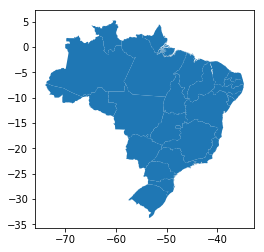

In [3]:
geodf.plot()

Vamos rapidamente tratar o arquivo csv que geramos, removendo colunas desnecessárias e renomeando o que for necessário. 

In [4]:
def read_and_organize():
    df = pd.read_csv('DfUnic.csv')
    df = df.drop(columns={df.columns[0]})
    df = df.drop(columns="cod ibge")
    # Colocando o nome como COD_UF para ficar ao de geodf no merge. 
    df = df.rename(index=str, columns={"cod uf": "COD_UF"}) 
    return df

df = read_and_organize()
df.head()

,ano,região,COD_UF,uf,município,sexo,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,2009,CENTRO-OESTE,53,DF,BRASILIA,M,0,1,9,0.0,10.0
1,2009,CENTRO-OESTE,52,GO,ABADIA DE GOIAS,M,0,0,3,0.0,3.0
2,2009,CENTRO-OESTE,52,GO,ABADIANIA,M,0,1,12,1.0,14.0
3,2009,CENTRO-OESTE,52,GO,ACREUNA,M,0,0,24,3.0,27.0
4,2009,CENTRO-OESTE,52,GO,ADELANDIA,M,0,0,0,0.0,0.0


Agruparemos, então, as informações por Estado. 

In [5]:
# Juntando as informações de todas as cidades por estado, de ambos os sexos. 
states_df = df.groupby(['COD_UF', 'ano'], as_index=False).sum()
states_df.head()

,COD_UF,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,11,2008,17,43,2259,243.0,2562.0
1,11,2009,20,66,2694,367.0,3147.0
2,11,2010,45,93,3592,403.0,4133.0
3,11,2011,22,62,2012,215.0,2311.0
4,11,2012,37,94,3581,400.0,4112.0


### Mesclando os dados ###

Temos, portanto, uma tabela com informações geográficas e uma tabela com informações nutricionais a respeito dos estados. Mas precisamos cruzar esses dados, mesclando as tabelas. Usamos o COD_UF, comum a ambas as tabelas, para o ponto de referência entre as tabelas.

In [6]:
# Fazendo o merge das informações do shapefile com o dataframe obtido pelo sisvan. 
# Assim, temos um dataframe contendo informações gerais do estado (todas as cidades)
# e de ambos os sexos, além da forma do estado, pois possui a coluna 'geometry' do shapefile
merged = geodf.merge(states_df, on='COD_UF')
merged.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,9,26,824,87.0,946.0
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17,34,1047,125.0,1223.0
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,24,66,1846,200.0,2136.0
3,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2011,19,38,1299,158.0,1514.0
4,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2012,21,46,1630,190.0,1887.0


Temos, então, informações geográficas e informações nutricionais em uma única tabela, como desejado. O próximo passo é obter os percentuais, caso seja desejado saber os dados em relação ao total. Percentuais muitas vezes oferecem uma análise mais fiel à realidade.

In [8]:
def get_percentages(merged):
    merged['percent_muitobaixo'] = 100 * (merged['peso muito baixo'] / merged['total'])
    merged['percent_baixo'] = 100 * (merged['peso baixo'] / merged['total'])
    merged['percent_adequado'] = 100 * (merged['peso adequado'] / merged['total'])
    merged['percent_elevado'] = 100 * (merged['peso elevado'] / merged['total'])
    return merged

# Obtendo o percentual para o gráfico ficar mais fiel na representação da realidade
merged = get_percentages(merged)
merged.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total,percent_muitobaixo,percent_baixo,percent_adequado,percent_elevado
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,9,26,824,87.0,946.0,0.951374,2.748414,87.103594,9.196617
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17,34,1047,125.0,1223.0,1.390025,2.780049,85.609158,10.220769
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,24,66,1846,200.0,2136.0,1.123596,3.089888,86.423221,9.363296
3,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2011,19,38,1299,158.0,1514.0,1.254954,2.509908,85.799207,10.435931
4,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2012,21,46,1630,190.0,1887.0,1.112878,2.437732,86.380498,10.068892


### Escolhendo o ano desejado ###

Troque o valor na célula abaixo para escolher o ano em que deseja ver os dados dos mapas. Em seguida, execute as células abaixo.

In [11]:
# ALTERE AQUI o ano em que você deseja ver os dados. Em seguida, execute novamente as células abaixo. 
'''
Possível escolher anos de 2008 a 2018. Tente você mesmo!
'''
year = 2018

A partir do ano escolhido, será criado um subset apenas com o ano escolhido. Então as colunas serão renomeadas para nomes sem espaços, para que possam ser tratadas como variáveis.

In [25]:
#Pegando informações apenas do ano desejado
merged_year = merged.loc[merged['ano'] == year]
merged_year.columns = ['ESTADOS', 'REGIAO', 'COD_UF', 'UF', 'geometry', 'ano', 'muitobaixo', 
                      'baixo', 'adequado', 'elevado', 'total', 'percent_muitobaixo', 'percent_baixo',
                      'percent_adequado', 'percent_elevado']
merged_year.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,muitobaixo,baixo,adequado,elevado,total,percent_muitobaixo,percent_baixo,percent_adequado,percent_elevado
10,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2018,110,263,7829,635.0,8837.0,1.244766,2.976123,88.593414,7.185697
21,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2018,418,691,23479,2930.0,27518.0,1.519006,2.511084,85.322334,10.647576
32,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...,2018,69,164,4721,355.0,5309.0,1.299680,3.089094,88.924468,6.686758
43,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...,2018,688,1392,31439,2592.0,36111.0,1.905237,3.854781,87.062114,7.177868
54,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...,2018,1403,2977,103825,10640.0,118845.0,1.180529,2.504943,87.361690,8.952838


### Mapa coroplético ###
O [mapa coroplético]("https://pt.wikipedia.org/wiki/Mapa_coroplético") foi esoclhido para essas representações pois ele comunica de maneira intuitiva ao visualizador comum informações estatísticas em determinadas áreas (no caso, unidades federativas do Brasil), permitindo comparar com diferentes áreas.

A partir do ano escolhido, verificamos os máximos e os mínimos de cada um dos percentuais, para que a régua de cores da legenda represente mais fielmente a realidade. O código cria funções que fazem o mapa esperando como parâmetros a paleta de cores do mapa e o percentual que o mapa representará.

In [26]:
def get_vmin_and_vmax(variable):
    if(variable == 'percent_muitobaixo'):
        return merged_year.percent_muitobaixo.min(), merged_year.percent_muitobaixo.max()
    elif(variable == 'percent_baixo'):
        return merged_year.percent_baixo.min(), merged_year.percent_baixo.max()
    elif(variable == 'percent_adequado'):
        return merged_year.percent_adequado.min(), merged_year.percent_adequado.max()
    elif(variable == 'percent_elevado'):
        return merged_year.percent_elevado.min(), merged_year.percent_elevado.max()
    else:
        return 0,100

def choropleth_plots(variable, colors):
    merged_year.plot(column=variable, cmap=colors, linewidth=0.2, ax=ax, edgecolor='0.3')

    ax.axis('off')
    #ax.set_title('Peso muito baixo por estado (percentual)', fontdict={'fontsize': '16'})
    ax.annotate('Fonte: Relatórios do SISVAN (DATASUS)', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

    # Barra de cores
    vmin, vmax = get_vmin_and_vmax(variable)
    sm = mpl.cm.ScalarMappable(cmap=colors, norm=mpl.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    ax

Abaixo a função de criar o mapa coroplético é chamada uma vez para uma das colunas de percentual, cada uma com uma cor diferente para melhorar a visualização. 

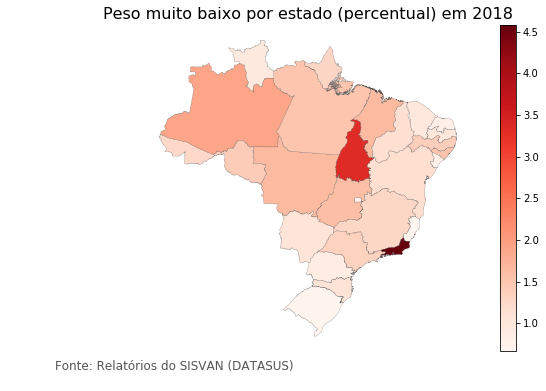

In [27]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso muito baixo por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_muitobaixo', colors="Reds")

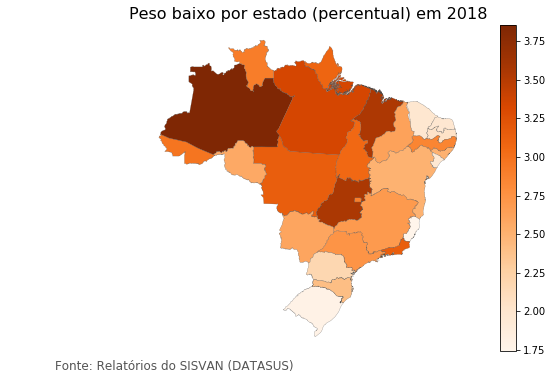

In [28]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso baixo por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_baixo', colors="Oranges")


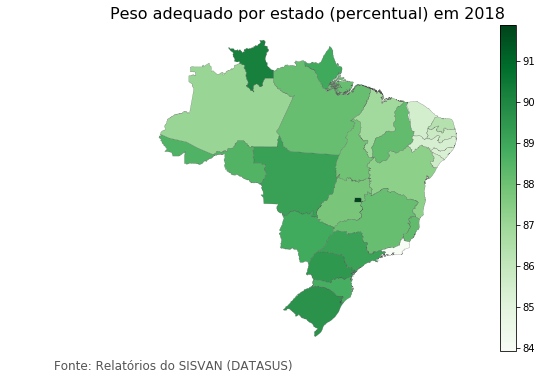

In [29]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso adequado por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_adequado', colors="Greens")

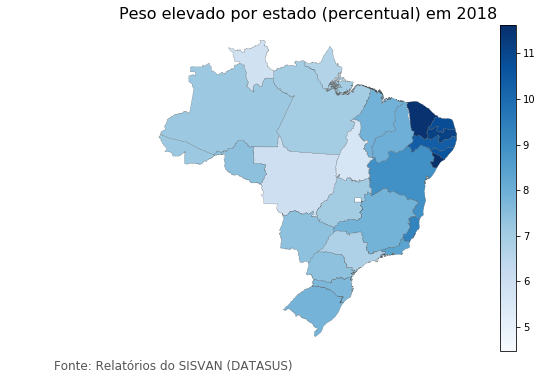

In [30]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso elevado por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_elevado', colors="Blues")

### Gráficos interativos ###

Para os gráficos interativos, usaremos a biblioteca [Plotly]("https://plot.ly").
Começaremos importando todos os componentes necessários.

In [41]:
import plotly 
import plotly.offline as py
import plotly.graph_objs as go

Em seguida, criaremos o ambiente com o dataframe desejado para a exibição dos gráficos. Agruparemos as informações por estados a partir do arquivo .csv criado a partir [deste código]("https://github.com/victoraccete/ICD_20182/blob/final_notebook/cleanandmerge.py"), renomeado como DfUnic.csv e que está presente no repositório.

In [42]:
def setup_df():
    #plotly.tools.set_credentials_file(username='pedro.vitorino20',
                                  #api_key='plotsICD')        
    df = pd.read_csv('DfUnic.csv')
    df.head()    
    states_df = df.groupby(['cod uf', 'uf', 'sexo', 'ano'], as_index = False).sum()
    states_df = states_df.drop('cod ibge', axis = 1)
    return states_df

Com isso nós podemos criar a estrutura para plotar nossos gráficos, na forma de uma função que espera como parâmetros o código do Estado que será gerado o gráfico e o dataframe.

In [36]:
def create_plots(state_cod, states_df):
    df_statesM = states_df[states_df['cod uf']==state_cod][states_df['sexo'] 
                            == 'M']
    state_name = df_statesM['uf'].iloc[0]
    
    
    df_statesM.ano = pd.to_datetime(states_df.ano, format='%Y')
    
    trace0 = go.Scatter(
                    x=df_statesM.ano,
                    y=df_statesM['peso muito baixo'],
                    name = "Peso Muito Baixo",
                    line = dict(color = '#990000'),
                    opacity = 0.8)
    
    trace1 = go.Scatter(
                    x=df_statesM.ano,
                    y=df_statesM['peso baixo'],
                    name = "Peso Baixo",
                    line = dict(color = 'orange'),
                    opacity = 0.8)
                    
    trace2 = go.Scatter(
                    x=df_statesM.ano,
                    y=df_statesM['peso adequado'],
                    name = "Peso Adequado",
                    line = dict(color = 'green'),
                    opacity = 0.8)
    
    trace3 = go.Scatter(
                    x=df_statesM.ano,
                    y=df_statesM['peso elevado'],
                    name = "Peso Elevado",
                    line = dict(color = 'blue'),
                    opacity = 0.8)
        
    df_states_F = states_df[states_df['cod uf']==state_cod][states_df['sexo'] 
                            == 'F']
    
    df_states_F.ano = pd.to_datetime(df_states_F.ano, format='%Y')
    
    trace4 = go.Scatter(
                    x=df_states_F.ano,
                    y=df_states_F['peso muito baixo'],
                    name = "Peso Muito Baixo",
                    line = dict(color = '#990000'),
                    opacity = 0.8,
                    xaxis='x2',
                    yaxis='y2')
    
    trace5 = go.Scatter(
                    x=df_states_F.ano,
                    y=df_states_F['peso baixo'],
                    name = "Peso Baixo",
                    line = dict(color = 'orange'),
                    opacity = 0.8,
                    xaxis='x2',
                    yaxis='y2')
                    
    trace6 = go.Scatter(
                    x=df_states_F.ano,
                    y=df_states_F['peso adequado'],
                    name = "Peso Adequado",
                    line = dict(color = 'green'),
                    opacity = 0.8,
                    xaxis='x2',
                    yaxis='y2')
    
    trace7 = go.Scatter(
                    x=df_states_F.ano,
                    y=df_states_F['peso elevado'],
                    name = "Peso Elevado",
                    line = dict(color = 'blue'),
                    opacity = 0.8,
                    xaxis='x2',
                    yaxis='y2')
    
    trace8 = go.Box(y = states_df.loc[states_df['sexo'] == "M", 'peso muito baixo'],
                    name = 'Peso Muito Baixo-M',
                    marker = {'color': '#ff0000'},
                    xaxis='x3',
                    yaxis='y3')
                             
    trace9 = go.Box(y = states_df.loc[states_df['sexo'] == "F", 'peso muito baixo'],
                    name = 'Peso Muito Baixo-F',
                    marker = {'color': '#ffcccc'},
                    xaxis='x3',
                    yaxis='y3')
                              
    trace10 = go.Box(y = states_df.loc[states_df['sexo'] == "M", 'peso baixo'],
                    name = 'Peso Baixo-M',
                    marker = {'color': '#ff8000'},
                    xaxis='x3',
                    yaxis='y3')
                              
    trace11 = go.Box(y = states_df.loc[states_df['sexo'] == "F", 'peso baixo'],
                    name = 'Peso Baixo-F',
                    marker = {'color': '#ffff99'},
                    xaxis='x3',
                    yaxis='y3')
    
    trace12 = go.Box(y = states_df.loc[states_df['sexo'] == "M", 'peso adequado'],
                    name = 'Peso Adequado-M',
                    marker = {'color': '#006600'},
                    xaxis='x3',
                    yaxis='y3')
                              
    trace13 = go.Box(y = states_df.loc[states_df['sexo'] == "F", 'peso adequado'],
                    name = 'Peso Adequado-F',
                    marker = {'color': '#99ff99'},
                    xaxis='x3',
                    yaxis='y3')
    
    trace14 = go.Box(y = states_df.loc[states_df['sexo'] == "M", 'peso elevado'],
                    name = 'Peso Elevado-M',
                    marker = {'color': '#000080'},
                    xaxis='x3',
                    yaxis='y3')
                              
    trace15 = go.Box(y = states_df.loc[states_df['sexo'] == "F", 'peso elevado'],
                    name = 'Peso Elevado-F',
                    marker = {'color': '#b3daff'},
                    xaxis='x3',
                    yaxis='y3')
    
    layout = go.Layout(
            dict(title = "Estado Por Peso " + state_name),
            xaxis=dict(
            title = "Masculino", 
            domain=[0, 0.45]
        ),
        yaxis=dict(
            domain=[0, 0.45]
        ),
         xaxis2=dict(
            title = "Feminino",
            domain=[0.55, 1]
        ),
        yaxis2=dict(
            domain=[0, 0.45],
            anchor='x2'
        ),
        xaxis3=dict(
            domain=[0, 1],
            anchor='y3'
        ),
        yaxis3=dict(
            domain=[0.55, 1]
        )
    )
        
    data = [trace0,trace1, trace2, trace3, trace4, trace5, trace6, trace7,
            trace8, trace9, trace10, trace11, trace12, trace13, trace14, trace15]
    
    fig = dict(data=data, layout=layout)
    return fig

A função abaixo garante que sejam gerados gráficos referentes a cada um dos estados do dataframe passado como parâmetro. O objetivo é exportar, para cada um dos estados, um arquivo .html contendo gráficos interativos referentes ao estado. 

In [43]:
def generate_plots_for_all_states(states_df):
    # Criando esse novo DF para ter um DF apenas como uma lista de todos os
    # estados e seus respectivos códigos
    states_only = states_df.groupby(['cod uf', 'uf'], as_index = False).sum()
    for index, row in states_only.iterrows():
        fig = create_plots(row['cod uf'], states_df)
        py.plot(fig, filename = 'plots/' + str(int(row['cod uf']))+ '.html', 
                auto_open=False)

Agora podemos plotar. 

Criamos o dataframe desejado e chamamos a função para criar os gráficos para cada um dos estados. Os arquivos .html serão armazenados no diretório [/plots]("https://github.com/victoraccete/ICD_20182/tree/final_notebook/plots"). 

In [45]:
states_df = setup_df()
generate_plots_for_all_states(states_df)

C:\Users\Victor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Victor\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



#### Mapa interativo ####

Agora, criaremos um mapa interativo em que o usuário pode clicar em cada um dos estados para obter . 

Para o mapa interativo, usaremos a biblioteca Bokeh. Primeiramente, transformamos o nosso dado em um arquivo do tipo geojson, passo necessário para a utilização da biblioteca.

In [38]:
# Criando um geojson
geojson = merged_year.to_json()
with open("jsondata.geojson", "w") as f:
    f.write(geojson)

Importando os componentes necessários:

In [39]:
from bokeh.io import show, output_file, reset_output#, output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Viridis256
from bokeh.models import ColumnDataSource, OpenURL, TapTool

#output_notebook()

Então, graças aos passos executados anteriormente, o mapa já está pronto para ser plotado através do código abaixo.
O mapa abrirá em uma nova página html, e os estados podem ser clicados para obter mais informações a respeito de cada um dos estados.

In [40]:
reset_output()  # Linha necessária, pois o Bokeh possui uma persistência fazendo com que múltiplas
                # execuções do trecho abaixo fizesse com que o arquivo .html gerado fizesse vários
                # mapas, um abaixo do outro
output_file("interactiveplot.html", mode="inline")

with open(r'jsondata.geojson') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())
        
cmap = LinearColorMapper(palette=Viridis256)

TOOLS = "tap,reset,hover,save"

br_map = figure(title='Estados do Brasil', tools=TOOLS, x_axis_location=None, y_axis_location=None, 
                width=500, height=500)
br_map.grid.grid_line_color = None

br_map.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'COD_UF', 'transform': cmap},
         line_color='black', line_width=0.5, source=geo_src)

hover = br_map.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [
    ('Estado', '@ESTADOS'), 
    ('Região', '@REGIAO')]

url = "plots/@COD_UF.html"
taptool = br_map.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(br_map)